In [204]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Path to the .mseed file
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1972-07-17HR00_evid00067.mseed' #request
mseed_file = f'{data_directory}'

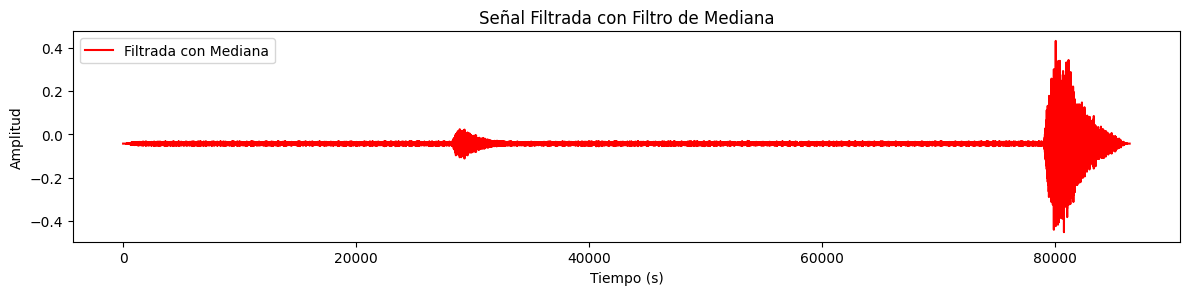

In [205]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Read the mseed file
st = read(mseed_file)
tr = st[0].copy()  # Obtain the first trace

# Apply a highpass filter
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtain filtered trace data
tr_times = tr.times()
tr_data = tr.data

# Min-Max normalization
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Apply a Median Filter
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualize the signals
plt.figure(figsize=(12, 8))

# Filtered Signal with Median
plt.subplot(3, 1,1)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('mediana.png')
plt.legend()

plt.tight_layout()
plt.show()

In [206]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calculate sampling rate
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

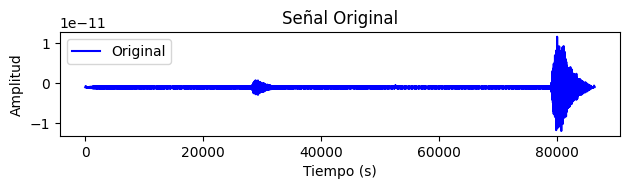

In [207]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [208]:
import re
def deserializar_respuesta(respuesta_texto):
    # Expresión regular para capturar valores de 'sta', 'lta' y 'confirmation'
    patron = r"'sta':\s*(\d+),\s*'lta':\s*(\d+),\s*'confirmation':\s*'(yes|no)'"
    
    # Buscar el patrón en el texto de respuesta
    match = re.search(patron, respuesta_texto)
    
    if match:
        sta = int(match.group(1))  # Extraer y convertir 'sta' a entero
        lta = int(match.group(2))  # Extraer y convertir 'lta' a entero
        confirmation = match.group(3)  # Extraer 'confirmation' (yes o no)
        return sta, lta, confirmation
    else:
        raise ValueError("No se pudo deserializar la respuesta. Formato inválido.")


In [209]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

gemini_api_key = os.getenv("API_KEY")

def upload_to_gemini(path, mime_type=None):
  file = genai.upload_file(path, mime_type=mime_type)
  return file

genai.configure(api_key=gemini_api_key)

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
)

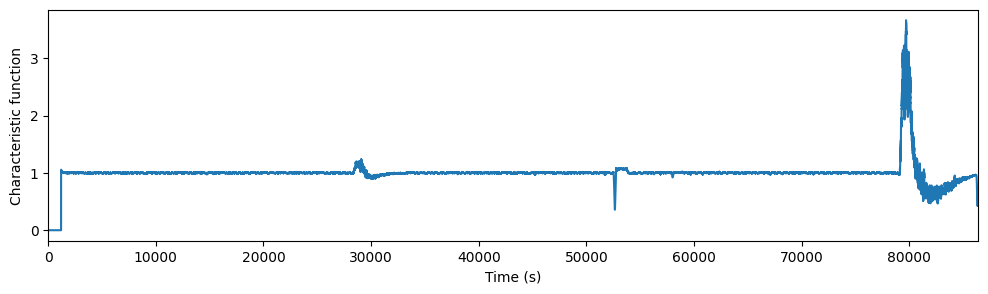

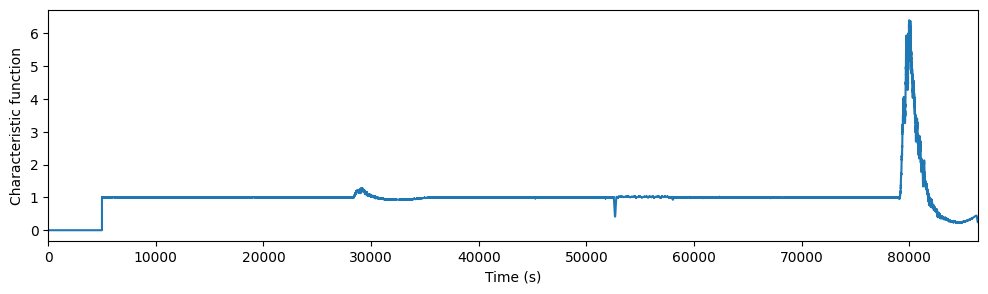

In [210]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

confirmation = "no"  # You want to set confirmation to "no" to begin the while loop
i = 0

# Sampling frequency of the trace
df = tr.stats.sampling_rate

while confirmation != "yes":
    if i == 0:
        # Default STA/LTA window lengths
        sta_len = 60  # Short-term window in seconds
        lta_len = 1200  # Long-term window in seconds
    else:
        # Use the updated window lengths from the user response
        sta_len, lta_len, confirmation = deserializar_respuesta(response.text)

    # Run Obspy's STA/LTA to obtain a characteristic function
    cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

    # Define the minimum event duration (in seconds)
    min_duration = 420  # Adjust as per requirements
    # Convert minimum duration to samples
    min_duration_samples = int(min_duration * df)

    # Plot the characteristic function
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    plt.savefig('caracteristica.png')  # Save the plot as an image

    response = model.generate_content([
        upload_to_gemini("caracteristica.png", mime_type="image/png"),
        "The graph is improving, but we need to optimize it further. Please suggest a new value for the STA and LTA windows to obtain a better graph. Respond **only** in the following format: {'sta': <new_sta_value>, 'lta': <new_lta_value>, 'confirmation': <yes or no>}. Make sure the response contains only values in this format."
    ])
    
    i += 1  # Increment the loop counter


Iteración 0: Probando con thr_on=12, thr_off=1
Iteración 1: Probando con thr_on=10, thr_off=1
Iteración 2: Probando con thr_on=6, thr_off=1
Iteración 3: Probando con thr_on=5, thr_off=1
Iteración 4: Probando con thr_on=4, thr_off=1
Iteración 5: Probando con thr_on=1.8, thr_off=1
Iteración 6: Probando con thr_on=1.5, thr_off=1
Iteración 7: Probando con thr_on=1.1, thr_off=1
Se encontraron 2 eventos válidos.


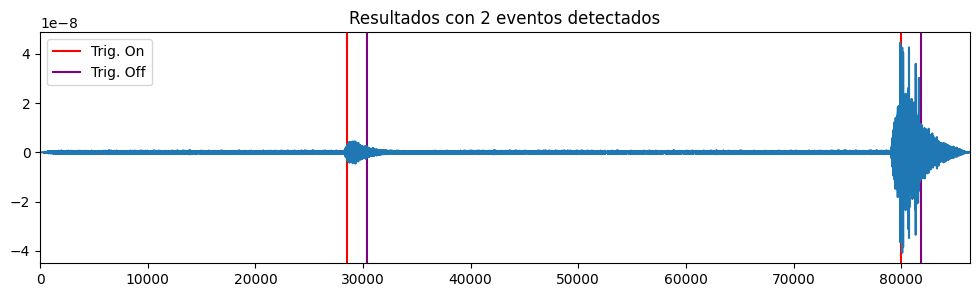

In [212]:
import numpy as np
import matplotlib.pyplot as plt

#l_threshold_on = [12,10,6,5,4,1.8,1.5,1.1]  # Activation thresholds list
#l_threshold_off = [1,1,1,1,1,1,1,1]  # Deactivation thresholds list
# Definir los umbrales para diferentes eventos
thresholds = [
    {'on': 12, 'off': 1},  # Umbrales para el primer evento
    {'on': 10, 'off': 1},  # Umbrales para el segundo evento
    {'on': 6, 'off': 1},  # Umbrales para el tercer evento
    {'on': 5, 'off': 1},  # Umbrales para el cuarto evento
    {'on': 4, 'off': 1},  # Umbrales para el quinto evento
    {'on': 1.8, 'off': 1},  # Umbrales para el sexto evento
    {'on': 1.5, 'off': 1},  # Umbrales para el séptimo evento
    {'on': 1.1, 'off': 1}  # Umbrales para el octavo evento
    # Agregar más o menos eventos según sea necesario

]

filtered_on_off = []  # Inicializa la lista que almacenará los eventos filtrados
min_duration_samples = 420  # Ejemplo de duración mínima para un evento

# Inicializar un conjunto para almacenar los tiempos de los triggers ya detectados
detected_events = set()

# Mientras que no se encuentren eventos válidos y haya más umbrales que probar
for idx, thr in enumerate(thresholds):
    thr_on = thr['on']  # Obtiene el umbral de activación actual
    thr_off = thr['off']  # Obtiene el umbral de desactivación actual
    
    print(f"Iteración {idx}: Probando con thr_on={thr_on}, thr_off={thr_off}")
    
    # Obtener los triggers usando los umbrales actuales
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # Filtrar los eventos que duren menos que el tiempo mínimo
    temp_filtered = []
    for triggers in on_off:
        if (triggers[1] - triggers[0]) >= min_duration_samples:
            # Comprobar si el evento se superpone con eventos ya detectados
            event_range = range(triggers[0], triggers[1] + 1)
            if not any(time in detected_events for time in event_range):
                temp_filtered.append(triggers)
                detected_events.update(event_range)  # Agregar el rango del evento detectado
    
    # Convertir la lista filtrada de nuevo a un arreglo NumPy
    temp_filtered = np.array(temp_filtered)
    
    # Solo almacenar los eventos válidos si se encontraron
    if len(temp_filtered) > 0:
        filtered_on_off.extend(temp_filtered.tolist())

# Si se encontraron eventos, gráficar
if len(filtered_on_off) > 0:
    print(f"Se encontraron {len(filtered_on_off)} eventos válidos.")

    # Graficar los triggers on y off (solo los filtrados)
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    for i in range(len(filtered_on_off)):
        triggers = filtered_on_off[i]
        ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
        ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
    
    # Graficar el sismograma
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])
    
    # Manejar la leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.title(f"Resultados con {len(filtered_on_off)} eventos detectados")
    plt.show()
else:
    print("No se encontraron eventos que cumplan la duración mínima en ninguno de los umbrales.")




In [213]:
filtered_on_off
print(filtered_on_off)
filtered_on_off = np.array(filtered_on_off)
filtered_on_off = filtered_on_off / df
filtered_on_off #end point

[[529588, 541914], [189010, 201372]]


array([[79937.81132075, 81798.33962264],
       [28529.81132075, 30395.77358491]])